# Vehicle Detection & Tracking
Udacity Project 5
Author: Kelly Smith

This Jupyter Notebook will train a classifier to identify vehicles using classic computer vision techniques (HOG, color histograms, sliding windows). 

In [72]:
# Import statements to get all requisite packages
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle
import os.path
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from scipy.ndimage.measurements import label

In [3]:
# Define constants for the pipeline
trainingDataFilename = "trainingData.p"
classifierFilename = "classifier.p"

# Issues

There are a ton of false positives.  Tune up the filtering?

The detection algorithm seems sensitive to the multi-scale windows.

I cannot get the heatmap method to apply the threshold for some @#$! reason.

The pipeline is slow as molasses.  Probably need to figure out the single-HOG-call approach. 

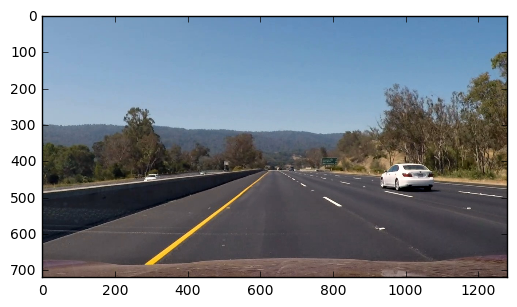

In [123]:
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb

# HOG Tuning Knobs
hog_feat = True # HOG features on or off
orient = 9  # HOG orientations
pix_per_cell = 4 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # "ALL" # Can be 0, 1, 2, or "ALL"

# Spatial Features Knobs
spatial_feat = True # True # Spatial features on or off
spatial_size = (16, 16) # Spatial binning dimensions

# Color Histogram Feature Knobs
hist_bins = 16    # Number of histogram bins
hist_feat = True # Histogram features on or off

HeatMapThreshold = 3

image = mpimg.imread('frames/frame400.jpg')
# image2 = mpimg.imread('frames/frame202.jpg')
heatmap = HeatMap(image)
test(image, Retrain=False, Debug=False, Mini=False)
# test(mpimg.imread('frames/frame401.jpg'))


In [4]:
"""
This is the test function for executing the overall pipeline on a single image.
"""
def test(image, Retrain=False, Debug=False, Mini=False):
    
    if Debug:
        print("Loading classifier...",end='')
    clf, X_scaler = setup(Retrain=Retrain, Debug=Debug, Mini=Mini)
    if Debug:
        print("Complete!")
    
    window_img = processImg(image, clf, X_scaler, Debug=Debug)                    

    plt.imshow(window_img)
    plt.show()
    

In [122]:
def processImg(image, clf, X_scaler, Debug=False):
    if Debug:
        print("Generating windows...",end='')
    #windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
    #                xy_window=(96, 96), xy_overlap=(0.5, 0.5))
    windows = multiScaleWindows(image)
    if Debug:
        print("Complete!")
        print("Generated %d windows" % (len(windows)))
    
    if Debug:
        print("Searching image windows...", end='')
    hot_windows = search_windows(image, windows, clf, X_scaler)
    if Debug:
        print("Complete!")
    
    heatmap.chill()
    for window in hot_windows:
        heatmap.warm(window)
    
    draw_img = np.copy(image)
    
    # draw_img = draw_boxes(draw_img, hot_windows, color=(0, 0, 255), thick=6)
    if Debug:
        draw_img = draw_boxes(draw_img, windows, color=(255,255,0), thick=1)
        # draw_img = draw_boxes(draw_img, hot_windows, color=(0, 0, 255), thick=6)
        plt.imshow(heatmap.getOverlay())
        plt.show()
        print("Max Heatmap Value = %d " % (np.max(heatmap.getOverlay())))
    
    hm = heatmap.thresholdHeatMap(HeatMapThreshold)
    
    if Debug:
        np.savetxt("heatmap_raw.txt",hm,"%d")
        print("Heatmap")
        plt.imshow(hm)
        plt.show()
    
    labeledCars, numCarsFound = label(hm)
    
    if Debug:
        print(numCarsFound, 'cars found')
        print("labeledCars BELOW")
        plt.imshow(labeledCars,cmap='gray')
        plt.show()
    
    draw_img = draw_labeled_bboxes(np.copy(draw_img), (labeledCars, numCarsFound))
    
    return draw_img

# Training
This section contains the code required to train a linear SVM to distinguish cars from non-car images.

In [6]:
"""
This is the primary setup function.  It can be configured to load an existing classifier (default) or 
to generate a newly trained classifier.  
    If the Retrain argument is false, then it will load an existing classifier and scaler.
    If the Retrain argument is true or no classifier file exists, then it will generate all the training data and retrain. 
"""
def setup(Retrain=False, Debug=False, Mini=False):
    if Retrain or not os.path.isfile(classifierFilename):
        # Train a new classifier 
        clf, X_scaler = trainClassifier(Retrain=Retrain, Debug=Debug, Mini=Mini)
        
        # Save the new classifier
        data = {"clf":clf, "X_scaler":X_scaler}
        with open (classifierFilename,"wb") as output_file:
            pickle.dump(data, output_file)
    else:
        # Load existing classifier
        with open (classifierFilename,"rb") as input_file:
            data = pickle.load(input_file)
        clf = data['clf']
        X_scaler = data['X_scaler']
    return clf, X_scaler

In [7]:
"""
This function will train a linear SVM from the sklearn library on the car and non-car images
"""
def trainClassifier(Retrain=False, Debug=False, Mini=False):
    # Instantiate the linear support vector classifier
    svc = LinearSVC()
    
    # If the training data has not been generated yet,
    if Retrain or not os.path.isfile(trainingDataFilename):
        # Build the training data.
        if Debug:
            print("No training data detected.  Building training data from scratch (hang tight for a minute)...", end='')
        X_train, y_train, X_test, y_test, X_scaler = buildTrainingData(Debug=Debug)
        if Debug:
            print("Finished building training data!")
    else:
        # Load the existing data.
        if Debug:
            print("Found existing training data.  Loading that to save time...",end='')
        X_train, y_train, X_test, y_test, X_scaler = loadTrainingData()
        if Debug:
            print("Complete!")
    
    if Debug:
        print("Training the classifier...",end='')
        
    if Mini:
        X_train = X_train[:500]
        y_train = y_train[:500]
    
    # Train the classifier on the training set.
    svc.fit(X_train, y_train)
    if Debug:
        print("Complete!")
    
    # Evaluate fit on test set
    if Debug:
        print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    
    return svc, X_scaler

# Training Data Generation
This section will assemble the training data.

In [30]:
"""
This function will prepare features and labels for training the classifier.
"""
def buildTrainingData(SaveData=True, Debug=False, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Get car features
    cars = glob.glob("vehicles/*/*.png")
    notcars = glob.glob("non-vehicles/*/*.png") 
    
    if Debug:
        print("There are %d cars examples." % (len(cars)))
        print("There are %d not-car examples." % (len(notcars)))
        print("Extracting features for cars...",end="")
    
    # Full Features set
    car_features = extract_features(cars)
    if Debug:
        print("Complete!")
        print("Extracting features for non-cars...",end="")
        
    
    notcar_features = extract_features(notcars)
    
    if Debug:
        print("Complete!")
    
    
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    
    if Debug:
        print(X.shape)
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    # If the SaveData flag is True, then save the data via pickle 
    # to avoid having to generate training data every time.
    # if SaveData:
        # saveTrainingData(X_train, y_train, X_test, y_test, X_scaler)
        
    return (X_train, y_train, X_test, y_test, X_scaler)

"""This function will save the training data via pickle"""
def saveTrainingData(X_train, y_train, X_test, y_test, X_scaler):
    data = {"X_train":X_train, "y_train":y_train, "X_test":X_test, "y_test":y_test, "X_scaler":X_scaler}
    with open (trainingDataFilename,"wb") as output_file:
        pickle.dump(data, output_file)
        print("Saved the training data to %s" % trainingDataFilename)
    
"""This function loads existing training data."""
def loadTrainingData():
    with open (trainingDataFilename,"rb") as input_file:
        data = pickle.load(input_file)
    return (data['X_train'], data['y_train'], data['X_test'], data['y_test'], data["X_scaler"])

# Feature Extraction Code

In [9]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        
        # Kludge to convert each image (read from PNG) to 0-255.
        # This will make it consistent with test files (JPG).
        image = (image*255).astype(np.uint8)
            
        features.append(single_img_features(image))

    # Return list of feature vectors
    return features

In [10]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [11]:
"""
This function returns a histogram of oriented gradients
"""
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [12]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Sliding Window Functions
This code will generate a list of windows that slide across the image.

In [13]:
"""
This function will perform a sliding window search over the image to identify vehicles.
"""
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

"""Test routine for sliding window algorithm."""
def test_sliding_window():
    img = mpimg.imread("test_images/test1.jpg")
    windows = slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(128, 128), xy_overlap=(0.75, 0.75))
                       
    window_img = draw_boxes(img, windows, color=(0, 0, 255), thick=6)                    
    plt.imshow(window_img)
    plt.show()
    
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [14]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        detectedCar = checkWindowForCar(img, window, clf, scaler)
        #7) If positive (prediction == 1) then save the window
        if detectedCar:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [15]:
def checkWindowForCar(img, window, clf, scaler):
    test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
    #4) Extract features for that window using single_img_features()
    features = single_img_features(test_img)
    #5) Scale extracted features to be fed to classifier
    reshapedFeatures = np.array(features).reshape(1, -1)
    
    test_features = scaler.transform(reshapedFeatures)
    #6) Predict using your classifier
    prediction = clf.predict(test_features)
    return prediction==1;

In [53]:
def multiScaleWindows(img):
    #windows = slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
    #                xy_window=(64, 64), xy_overlap=(0.5, 0.5))
    
    windowsSmall = slide_window(img, x_start_stop=[200, 800], y_start_stop=[400, 500], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5))
    # print(len(windowsSmall))
    windowsMedium = slide_window(img, x_start_stop=[300, None], y_start_stop=[400, None], 
                    xy_window=(128, 128), xy_overlap=(0.75, 0.75))
    # print(len(windowsMedium))
    windowsLarge = slide_window(img, x_start_stop=[400, 1100], y_start_stop=[350, 500], 
                    xy_window=(50, 50), xy_overlap=(0.5, 0.5))
    # print(len(windowsLarge))
    windows = windowsSmall + windowsMedium + windowsLarge
    return windows
    

# HeatMap Functionality

In [125]:
from scipy.ndimage.measurements import label

class HeatMap():
    def __init__(self, img):
        self.heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
        # self.heatmap = np.zeros((img.shape[0], img.shape[1]),dtype=np.uint8)
        # self.heatmap = np.zeros_like(img,dtype=np.uint8)
        self.decay = 1
        self.growth = 1
    """Process the detection of a car"""
    def warm(self, window):
        # print("Called recordDetection!")
        # Increment the selected pixels by +1
        self.heatmap[window[0][1]:window[1][1], window[0][0]:window[1][0]] += self.growth

    def chill(self):
        self.heatmap = self.heatmap - self.decay
        self.heatmap[np.where(self.heatmap < 0)] = 0
    
    def plot(self):
        plt.imshow(self.heatmap,cmap='gray')
        plt.show()
        
    def getOverlay(self):
        return np.copy(self.heatmap)
    
    def thresholdHeatMap(self, threshold):
        Z = np.copy(self.heatmap)
        Z[Z <= threshold] = 0
        # Z[self.heatmap > threshold] = 0
        
        return Z# labels
    
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        
        # print("bbox" + str(bbox))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Video Processing

In [33]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML



clf, X_scaler = setup()
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    
    # thresholds = {'SobelX':[0, 255], 'hls':[100, 255]}
    result = processImg(image, clf, X_scaler)
    return result

In [535]:
def exportFrames():
    """
    Code snippet to extract every image from the video and save as a JPG image.  
    This was used to obtain frames from the video that caused the pipeline trouble.
    I found this code snippet on StackOverflow: 
    http://stackoverflow.com/questions/33311153/python-extracting-and-saving-video-frames
    """
    vidcap = cv2.VideoCapture('project_video.mp4')
    success,image = vidcap.read()
    count = 0
    success = True
    while success:
        success,image = vidcap.read()
        cv2.imwrite("frames/frame%d.jpg" % count, image)     # save frame as JPEG file
        count += 1
    print("Complete!")
# exportFrames()

In [ ]:
white_output = 'ProjectSubmission.mp4'
clip1 = VideoFileClip("project_video.mp4")

# Re-initialize fresh instances of the HeatMap objects
image = mpimg.imread('frames/frame265.jpg')
# image2 = mpimg.imread('frames/frame202.jpg')
heatmap = HeatMap(image)

# Process video
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ProjectSubmission.mp4
[MoviePy] Writing video ProjectSubmission.mp4




  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 1/1261 [00:07<2:38:48,  7.56s/it]

  0%|          | 2/1261 [00:15<2:39:55,  7.62s/it]

  0%|          | 3/1261 [00:22<2:38:58,  7.58s/it]

  0%|          | 4/1261 [00:30<2:39:23,  7.61s/it]

  0%|          | 5/1261 [00:38<2:39:25,  7.62s/it]

  0%|          | 6/1261 [00:45<2:38:50,  7.59s/it]